# Select suitable MDL test

# Purpose
Find suitable roll decay tests from MDL, to reproduce in Motions later on.

# Methodology
Look at the results from the KLVCC2 ship.
* Load model tests from MDL
* Determine damping
* Predict with
    * SI
    * Ikeda

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
#plt.style.use('paper')

#import data
import copy
from mdldb.tables import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from mdldb.hdf5_file import Hdf5File

In [3]:
db = database.get_db()

In [4]:
sql = """
SELECT * from run
WHERE model_number='M5057-01-A' and test_type='roll decay';
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine)


In [5]:
df_rolldecays

,id,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp
0,21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,NaN,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
1,21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,NaN,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
2,21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,NaN,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None
3,21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None
4,21531,40188822,1,105,1,M5057-01-A,M5057-01-A,166,105.0,NaN,Roll decay,\\sspa.local\gbg\MDLdata\Gamla_Projekt\ascii_f...,None,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,2019-03-01,roll decay,MDL,None,None,None
5,21532,40188822,1,106,1,M5057-01-A,M5057-01-A,166,106.0,15.5,Roll decay,\\sspa.local\gbg\MDLdata\Gamla_Projekt\ascii_f...,None,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,2019-10-16,roll decay,MDL,None,None,None
6,21558,40188822,1,117,1,M5057-01-A,M5057-01-A,166,117.0,NaN,Surge decay,\\sspa.local\gbg\MDLdata\Gamla_Projekt\ascii_f...,None,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,2019-02-27,roll decay,MDL,None,None,None
7,21559,40188822,1,217,1,M5057-01-A,M5057-01-A,166,217.0,NaN,Roll decay,\\sspa.local\gbg\MDLdata\Gamla_Projekt\ascii_f...,None,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,\\sspa.local\gbg\LABmeasuredataMDL\40188822\00...,2019-03-01,roll decay,MDL,None,None,None


In [34]:
db_run = db.session.query(tables.Run).get(int(21338))

In [36]:
df,units = database.load_run(db_run, save_as_example=False, prefer_hdf5=True)

In [37]:
df.head()

,ap/amplitud,ap/cirkelorder,ap/execute,ap/kurs,ap/kursorder,ap/mode,ap/order,ap/pullout,ap/rodergrundvinkel,ap/wait,ap/zzamplitud,ap/zzorder,arr/cmd/arr,arr/cmd/fri,arr/ind/arr,arr/ind/fri,carriage/course,carriage/elaxel,carriage/psip,carriage/speed,carriage/xp,carriage/xp_east,carriage/xp_west,carriage/yp,carriage/zp,carriage/dxp,filter/rpm/length,filter/rpm/rpm,hull/acc/x1,hull/acc/y1,hull/acc/y2,hull/acc/z1,hull/acc/z2,hull/acc/z3,kb/scalefactor,ma/alfa,ma/beta,ma/connected,ma/delta,ma/gamma,theta,phi,ma/torkorr,mops/abb/in/stat1,mops/abb/in/stat2,mops/abb/in/bit0,mops/abb/in/bit1,mops/abb/in/bit2,mops/abb/out/stat1,mops/abb/out/stat2,mops/proj,mops/run,mops/ser,mops/test,mops/watchdog,mops/logtrig,mops/relt,modelpos/cog,modelpos/knotsfs,modelpos/pitchm,modelpos/psidiff,modelpos/rollm,modelpos/sog,modelpos/xdiff,modelpos/xm,modelpos/yawm,modelpos/ydiff,modelpos/ym,modelpos/zm,prop/rpm,prop/thrust,prop/torque,rudder/angle,rudder/rate,rudder/roderorder,zmq/pos/msgtyp,zmq/video/msgtyp,lab/waveheight
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,-0.003,6.282487,0.0,-33.429,-31.998,-32.001,0.0,0.171,-1.43,NaN,0.0,-0.027858,-0.058632,-0.077177,0.049066,0.037150,-0.039169,68.0,0.000087,-0.004014,1.0,0.002094,-0.003316,-0.000087,-0.000262,0.0,0.0,24.0,0.0,1.0,0.0,NaN,NaN,40178362.0,2.0,1.0,4.0,3.0,1.0,271.349988,0.0,0.005596,-0.000087,-0.005411,-0.000262,0.000349,-0.004109,-33.433609,6.277077,-0.003300,-0.003300,0.000079,0.0,0.086924,-0.000061,0.000051,2.32,0.0,NaN,NaN,-0.000875
0.010002,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,-0.003,6.282487,0.0,-33.429,-31.998,-32.001,0.0,0.171,-1.43,NaN,0.0,0.031494,-0.008982,0.021638,0.005875,-0.046717,0.005937,68.0,0.000087,-0.004102,1.0,0.002094,-0.003316,-0.000262,-0.000262,0.0,0.0,24.0,0.0,1.0,0.0,NaN,NaN,40178362.0,2.0,1.0,4.0,4.0,1.0,271.359991,0.0,0.004897,-0.000262,-0.005411,-0.000262,0.000305,-0.004197,-33.433697,6.277077,-0.003299,-0.003299,0.000078,0.0,0.065396,-0.000385,-0.000586,2.32,0.0,NaN,NaN,-0.000875
0.020001,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,-0.003,6.282487,0.0,-33.429,-31.998,-32.001,0.0,0.171,-1.43,NaN,0.0,0.056654,0.043247,0.048764,-0.101135,-0.013815,0.101305,68.0,0.000087,-0.004014,1.0,0.002094,-0.003316,-0.000087,-0.000262,0.0,0.0,24.0,0.0,1.0,0.0,NaN,NaN,40178362.0,2.0,1.0,4.0,6.0,1.0,271.369990,0.0,0.004897,-0.000087,-0.005411,-0.000262,0.000305,-0.004109,-33.433609,6.277077,-0.003300,-0.003300,0.000079,0.0,0.094136,-0.001137,-0.000518,2.32,0.0,NaN,NaN,-0.000850
0.030001,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,-0.003,6.282487,0.0,-33.429,-31.998,-32.001,0.0,0.171,-1.43,NaN,0.0,0.100523,-0.004469,0.067494,-0.049564,-0.018331,0.055554,68.0,0.000087,-0.004102,1.0,0.002094,-0.003316,-0.000262,-0.000262,0.0,0.0,24.0,0.0,1.0,0.0,NaN,NaN,40178362.0,2.0,1.0,4.0,7.0,1.0,271.379989,0.0,0.004897,-0.000262,-0.005411,-0.000262,0.000305,-0.004197,-33.433697,6.277077,-0.003299,-0.003299,0.000078,0.0,0.102354,0.000018,-0.000632,2.32,0.0,NaN,NaN,-0.000800
0.040000,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,-0.003,6.282487,0.0,-33.429,-31.998,-32.001,0.0,0.171,-1.43,NaN,0.0,0.045042,-0.052184,0.057806,0.011032,-0.036395,0.056843,68.0,0.000087,-0.004102,1.0,0.002094,-0.003316,-0.000087,-0.000262,0.0,0.0,24.0,0.0,1.0,0.0,NaN,NaN,40178362.0,2.0,1.0,4.0,7.0,1.0,271.389988,0.0,0.004197,-0.000087,-0.005411,-0.000262,0.000262,-0.004197,-33.433697,6.277077,-0.003299,-0.003299,0.000078,0.0,0.063805,-0.000506,-0.000177,2.32,0.0,NaN,NaN,-0.000475


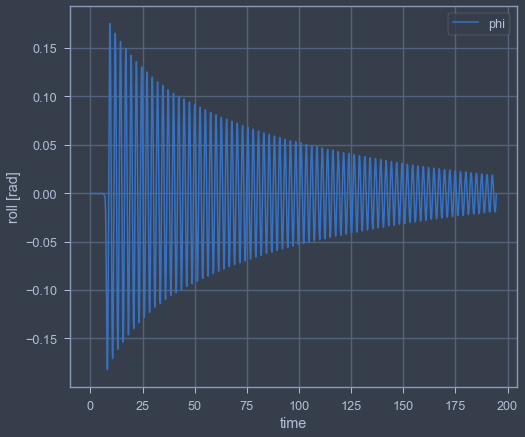

In [38]:
fig,ax=plt.subplots()
df.plot(y='phi', ax=ax)
ax.set_ylabel(f"roll [{units['phi']}]")
ax.grid(True)